<a href="https://colab.research.google.com/github/hashimmg/jax_IB/blob/main/Flapping_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [82]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
import jax
jax.config.update("jax_enable_x64", True)

In [84]:
import numpy as np
import tree_math as tm
import jax
import jax.numpy as jnp
from jax_ib.base import particle_class as pc
from jax_ib.base import grids, interpolation, fast_diagonalization, boundaries, pressure, diffusion, advection, finite_differences, IBM_Force,convolution_functions,particle_motion, equations
import jax_cfd.base as cfd
import jax_ib.MD as MD
from jax import random
from jax_md import space, quantity
import jax_ib
import jax_ib.base as ib
from jax_ib.base import kinematics as ks
from jax.random import uniform as random_uniform
import matplotlib.pyplot as plt
import functools as fct
import scipy 
import tree_math
from jax.experimental.pjit import pjit
from jax_ib.base import array_utils
import jax
from jax.sharding import NamedSharding
from jax.experimental.custom_partitioning import custom_partitioning
from jax.experimental.pjit import pjit
from jax.sharding import PartitionSpec as P
from jax.sharding import Mesh
#import regex as re
import functools
from functools import partial
import jax
import jax.numpy as jnp
from jax.sharding import Mesh, PartitionSpec as P
from jax.experimental.shard_map import shard_map
from jax_ib.base import xfft, utils
import functools
from functools import partial
import jax
import jax.numpy as jnp
from jax.sharding import Mesh, PartitionSpec as P
from jax.experimental.shard_map import shard_map
import numpy as np
import jax_ib.base.fft as fft
import scipy as sp
from scipy import linalg
from jax_ib.base import fast_diagonalization as fdiag

In [85]:
N = 128
M = 8
α, β = 1,1
As = [[None for _ in range(M)] for _ in range(M)]
subA = np.exp(-2*np.pi*1j*np.outer(np.arange(N//M), np.arange(N//M))/N)
exp =  np.exp(-2*np.pi*1j*np.outer(np.arange(N), np.arange(N))/N)
cols = [ np.exp(-2*np.pi*1j/N*j*(N//M) * np.arange(N//M)) for j in range(M)]
rows = [np.exp(-2*np.pi*1j/N*i*(N//M) * np.arange(N//M)) for i in range(M)]
x = np.random.rand(N).astype(np.complex64)
result = []
for i in range(M):
    for j in range(M):
        phase = np.exp(-2*np.pi*1j/N * i * j * (N//M)**2)
        As[i][j] = cols[j][:,None]*subA * rows[i][None,:] * phase
for i in range(M):
    temp = np.zeros(N//M, dtype=complex)
    for j in range(M):
        phase = np.exp(-2*np.pi*1j/N * i * j * (N//M)**2)
        temp += cols[j]*np.fft.fft(rows[i] *x[j*(N//M):(j+1)*(N//M)], N)[:(N//M)]* phase
    result.append(temp)
    
A = np.exp(-2*np.pi*1j*np.outer(np.arange(N), np.arange(N))/N)
y1 = np.fft.fft(x)
y2 = np.concatenate(result)
A2 = np.concatenate([np.concatenate(As[m], axis=1) for m in range(M)], axis=0)

In [86]:
mesh = jax.make_mesh(axis_shapes = (4,2), axis_names = ('i','j'))

In [87]:
density = 1.0    # fluid density
viscosity = 0.2 # fluid viscocity
dt=5e-3          # time step 
num_boundaries = 4
domain = ((0,15),(0,15))
mesh = jax.make_mesh((4,2), ('i','j'))
grid = grids.Grid((32,32), domain=domain, device_mesh = mesh, periods = (15,15))
bc_fns = [lambda t: 0.0 for _ in range(4)]
vx_bc=((0.0, 0.0), (0.0, 0.0))
vy_bc=((0.0, 0.0), (0.0, 0.0))

velocity_bc = (boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=vx_bc,bc_fn=bc_fns,time_stamp=0.0),
               boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=vy_bc,bc_fn=bc_fns,time_stamp=0.0))

vx_fn = lambda x, y: jnp.zeros_like(x)
vy_fn = lambda x, y: jnp.zeros_like(x)
vx_0, vy_0 = tuple(
    [
       grids.GridVariable
        (
           grid.eval_on_mesh(fn = lambda x, y: jnp.ones_like(x), offset = offset), bc # initial values for fluid velocities are 0 both in x and y direction
        ) 
        for offset, bc in zip(grid.cell_faces,velocity_bc)
    ]
)

v0 = (vx_0, vy_0)
global_pressure = grids.GridVariable(
    grids.GridArray(jnp.ones(grid.shape), grid.cell_center, grid), 
    boundaries.get_pressure_bc_from_velocity((vx_0, vy_0)))


subgrid=grid.subgrid((1,1),boundary_layer_widths=(1,1))

In [101]:
density = 1.0    # fluid density
viscosity = 0.05 # fluid viscocity
dt=5e-4          # time step 
num_boundaries = 4
domain = ((0,5.0),(0,5.0))
grid = grids.Grid((2**8, 2**8), domain=domain, device_mesh = mesh, periods = (5,5))
bc_fns = [lambda t: 0.0 for _ in range(4)]
vx_bc=((0.0, 0.0), (0.0, 0.0))
vy_bc=((0.0, 0.0), (0.0, 0.0))
bc_fns = [lambda t: 0.0 for _ in range(4)]
vx_bc=((0.0, 0.0), (0.0, 0.0))
vy_bc=((0.0, 0.0), (0.0, 0.0))

velocity_bc = (boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=vx_bc,bc_fn=bc_fns,time_stamp=0.0),
               boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=vy_bc,bc_fn=bc_fns,time_stamp=0.0))
#velocity_bc = (boundaries.dirichlet_boundary_conditions(ndim=2,bc_vals=vx_bc,bc_fn=bc_fns,time_stamp=0.0),
#               boundaries.dirichlet_boundary_conditions(ndim=2,bc_vals=vy_bc,bc_fn=bc_fns,time_stamp=0.0))
vx_fn = lambda x, y: jnp.zeros_like(x)
vy_fn = lambda x, y: jnp.zeros_like(x)
velocities = tuple(
    [
       grids.GridVariable
        (
           grid.eval_on_mesh(fn = lambda x, y: jnp.array(np.random.rand(*x.shape)), offset = offset), bc # initial values for fluid velocities are 0 both in x and y direction
        ) 
        for offset, bc in zip(grid.cell_faces,velocity_bc)
    ]
)

pressure0 = grids.GridVariable(
           grid.eval_on_mesh(fn = lambda x, y: jnp.cos(x+y), offset = grid.cell_center),  boundaries.get_pressure_bc_from_velocity(velocities) 
        ) 


In [102]:
def convect(v):
    return tuple(advection.advect_upwind(u, v, dt) for u in v)

def ellipse(geometry_params, ntheta=200):
    A = geometry_params[0]
    B = geometry_params[1]
    xt = jnp.linspace(-A,A,ntheta)
    yt = B/A*jnp.sqrt(A**2-xt**2)
    xt_2 = jnp.linspace(A,-A,ntheta)[1:-1]
    yt2 = -B/A*jnp.sqrt(A**2-xt_2**2)
    return jnp.append(xt,xt_2),jnp.append(yt,yt2)


def ellipse_trajectory(ellipse_parameters, initial_center_of_mass_position, angular_rotation_speed, 
                       center_of_mass_motion_parameters, t):
    x, y = ellipse(ellipse_parameters, 200)
    amplitude, frequency = center_of_mass_motion_parameters
    center_of_mass = initial_center_of_mass_position + jnp.array([amplitude/2 * jnp.cos(2*jnp.pi*frequency*t), 0.0]) - jnp.array([amplitude/2, 0.0])
    xp = x*jnp.cos(angular_rotation_speed*t)-y*jnp.sin(angular_rotation_speed*t)+center_of_mass[0]                                                                                  
    yp = x*jnp.sin(angular_rotation_speed*t)+y*jnp.cos(angular_rotation_speed*t)+center_of_mass[1] 
    return xp, yp

surf_fn =  lambda field,xp,yp:convolution_functions.convolve(field,xp,yp,convolution_functions.gaussian)



@partial(shard_map, mesh=mesh, in_specs=(P('i','j'),(P('i','j'), P('i','j')), None,None,P(),None, P()), 
         out_specs=(P('i','j'), P('i','j')))
def evolve_navier_stokes(pressure_field, velocities, grid, boundary_layer_widths, diags, num_steps,dt):
    #create a subgrid for the current patch
    i = jax.lax.axis_index('i')
    j = jax.lax.axis_index('j')
    subgrid = grid.subgrid((i,j), boundary_layer_widths=boundary_layer_widths)
    explicit_update = equations.navier_stokes_explicit_terms(
        density=1.0, viscosity=1.0, dt=5E-4,grid=subgrid, convect=convect, diffuse=diffusion.diffuse, forcing=None)
    
    surface_velocity = lambda f,x,y: convolution_functions.mesh_convolve(f,x,y,convolution_functions.gaussian, axis_names=['i','j'])
    
    #forcex, forcey = IBM_Force.immersed_boundary_force(
    #    local_velocities, obj_fns, convolution_functions.gaussian, surface_velocity, t, dt)
          
    # hard coded boundary condition values in each direction
    bc_fns = [lambda t: 0.0 for _ in range(4)]
    ux_bc=((0.0, 0.0), (0.0, 0.0))
    uy_bc=((0.0, 0.0), (0.0, 0.0))
    pressure_bc = ((0.0, 0.0), (0.0, 0.0))
    
    pressure_bc = boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=pressure_bc,bc_fn=bc_fns,time_stamp=0.0)
    velocity_bcs = (boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=ux_bc,bc_fn=bc_fns,time_stamp=0.0),
                    boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=uy_bc,bc_fn=bc_fns,time_stamp=0.0))
    
    ux, uy = velocities
    ux_trajectory = []
    uy_trajectory = []
    pressure_trajectory = []
    for step in range(num_steps):
        t = step * dt
        local_pressure = extend(pressure_field, subgrid, pressure_bc)
        local_ux = extend(ux, subgrid, velocity_bcs[0])
        local_uy = extend(uy, subgrid, velocity_bcs[1])

    
        explicit = explicit_update((local_ux, local_uy))
        dP = finite_differences.forward_difference(local_pressure)

        local_u_star = tuple([u.data + dt * e.data - dp.data for u, e, dp in zip((local_ux, local_uy), explicit, dP)])
        local_u_star = tuple([grids.GridVariable(
            grids.GridArray(u, os, subgrid), bc) for os, u, bc in zip(subgrid.cell_faces, local_u_star, velocity_bcs)])
        #forces = IBM_Force.immersed_boundary_force(
        #    local_u_star,[ellipse_position],convolution_functions.gaussian,surf_fn, t, dt)
      
        #local_u_star_star = tuple([u.data + dt * force.data for u, force in zip(local_u_star, forces)])
        local_u_star_star = tuple([grids.GridVariable(grids.GridArray(u, offset, subgrid), bc) for u, bc, offset in zip(local_u_star_star, velocity_bcs, subgrid.cell_faces)])
        local_u_final, new_local_pressure= pressure.projection_and_update_pressure_pinv(local_pressure, local_u_star_star, pinv)
        
        ux = local_u_final[0].data[1:-1,1:-1]
        uy = local_u_final[1].data[1:-1,1:-1]
        
        pressure_field = new_local_pressure.data[1:-1,1:-1]
        ux_trajectory.append(ux)
        uy_trajectory.append(uy)
        pressure_trajectory.append(pressure_field)
    return jnp.stack(ux_trajectory, axis=2), jnp.stack(uy_trajectory, axis=2)





In [103]:
def solve_linear(velocities, pinv, width)->grids.GridArray:
    subgrid = velocities[0].grid
    pressure_bc = boundaries.get_pressure_bc_from_velocity(velocities)
    extended_velocities = tuple([extend(v, width) for v in velocities])
    rhs_extended = finite_differences.divergence(extended_velocities)
    rhs = crop(grids.GridVariable(rhs_extended, velocities[0].bc), width)
    return grids.GridArray(pinv(rhs.data), rhs.offset, rhs.grid)

def projection_and_update_pressure_sharded(
    pressure: grids.GridVariable, 
    velocities: tuple[grids.GridVariable], pinv:callable, width:int
) -> grids.GridVariableVector:
    grid = pressure.grid
    pressure_bc = boundaries.get_pressure_bc_from_velocity(velocities)
    solution = grids.GridVariable(solve_linear(velocities, pinv, width), pressure_bc)
    new_pressure_array =  grids.GridArray(solution.data + pressure.data,pressure.offset,grid)
    new_pressure = grids.GridVariable(new_pressure_array,pressure_bc)
    
    extended_solution = extend(solution, width)
    grads = finite_differences.forward_difference(extended_solution)
    grads = tuple([crop(grids.GridVariable(grids.GridArray(g.data, g.offset, g.grid), solution.bc)) for g in grads])
    
    v_projected = tuple(grids.GridVariable(u.array - g.array, u.bc) for u, g in zip(velocities, grads))
    return v_projected, new_pressure

@partial(jax.jit, static_argnums = (3,))
@partial(shard_map, mesh=mesh, 
         in_specs = (P('i','j'),(P('i','j'), P('i','j')), (P('i'),P('j')), None), 
         out_specs = (P('i','j'),P('i','j')))
def wrapper(pressure_array, velocities, laplacian_eigenvalues, width):
    bc_fns = [lambda t: 0.0 for _ in range(4)]
    ux_bc=((0.0, 0.0), (0.0, 0.0))
    uy_bc=((0.0, 0.0), (0.0, 0.0))
    pressure_bc = ((0.0, 0.0), (0.0, 0.0))
    grid = pressure_array.grid
    pressure_bc = boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=pressure_bc,bc_fn=bc_fns,time_stamp=0.0)
    velocity_bcs = (boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=ux_bc,bc_fn=bc_fns,time_stamp=0.0),
                    boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=uy_bc,bc_fn=bc_fns,time_stamp=0.0))
    
    i = jax.lax.axis_index('i')
    j = jax.lax.axis_index('j')    
    subgrid = grid.subgrid((i,j), boundary_layer_widths=(width,width))
    pressure_var = grids.GridVariable(grids.GridArray(pressure_array.data, pressure_array.offset, subgrid),pressure_bc)
    velocities = tuple([grids.GridVariable(grids.GridArray(v.data, v.offset, subgrid),velocity_bcs[n]) for n, v in enumerate(velocities)])
    cutoff = 10 * jnp.finfo(jnp.float32).eps
    eigvals = jnp.add.outer(laplacian_eigenvalues[0], laplacian_eigenvalues[1].T)
    pinv = fdiag.pseudo_poisson_inversion(eigvals, jnp.complex128, ('i','j'), cutoff)  
    v_projected, new_pressure = pressure.projection_and_update_pressure_sharded(pressure_var, velocities, pinv,width)
    return tuple([v.array for v in v_projected]), new_pressure.array
    
    
    

In [104]:
eigvals = tuple([np.fft.fft(array_utils.laplacian_column(size, step)) for size, step in zip(grid.shape, grid.step)])

In [105]:
v_projected, new_pressure = pressure.projection_and_update_pressure(pressure0, velocities)

In [108]:
v_projected2, new_pressure2 = wrapper(pressure0.array, tuple([v.array for v in velocities]), eigvals, 1)

In [107]:
print(np.linalg.norm(v_projected[0].data - v_projected2[0].data))
print(np.linalg.norm(v_projected[1].data - v_projected2[1].data))
print(np.linalg.norm(new_pressure2.data - new_pressure.data))

1.181632908789442e-12
1.244720070889928e-12
4.210203190097082e-13


In [80]:
@partial(shard_map, mesh=mesh, in_specs=((P('i','j'),P('i','j')), None,None,None), 
         out_specs=(P('i','j'),P('i','j')))
def explicit_update_distributed(velocities, grid, boundary_layer_widths,dt):
    #create a subgrid for the current patch
    i = jax.lax.axis_index('i')
    j = jax.lax.axis_index('j')
    subgrid = grid.subgrid((i,j), boundary_layer_widths=boundary_layer_widths)
    def convect(v):
        return tuple(advection.advect_upwind(u, v, dt) for u in v)       
    
    explicit_update = equations.navier_stokes_explicit_terms(
        density=1.0, viscosity=1.0, dt=dt,grid=subgrid, convect=convect, diffuse=diffusion.diffuse, forcing=None)
  
    # hard coded boundary condition values in each direction
    bc_fns = [lambda t: 0.0 for _ in range(4)]
    ux_bc=((0.0, 0.0), (0.0, 0.0))
    uy_bc=((0.0, 0.0), (0.0, 0.0))
    
    velocity_bcs = (boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=ux_bc,bc_fn=bc_fns,time_stamp=0.0),
                    boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=uy_bc,bc_fn=bc_fns,time_stamp=0.0))
    
    ux, uy = velocities
    local_shape = ux.shape
    width = boundary_layer_widths[0]
    local_ux = add_halo_layer(ux, width)
    local_uy = add_halo_layer(uy, width)
    
    local_ux = grids.GridVariable(grids.GridArray(local_ux, subgrid.cell_faces[0], subgrid), velocity_bcs[0])
    local_uy = grids.GridVariable(grids.GridArray(local_uy, subgrid.cell_faces[1], subgrid), velocity_bcs[1])
    explicit = explicit_update((local_ux, local_uy))
    blw = boundary_layer_widths
    return tuple([e.data[blw[0]:blw[0] + local_shape[0],blw[1]:blw[1] + local_shape[1]] for e in explicit])


def test_explicit_update(velocity_field, density=1, viscosity=0.05, dt=5E-4, domain = ((0,15.),(0,15.0)), width=1):
    num_boundaries = 4
    device_mesh = jax.make_mesh((4, 2), ('i', 'j'))
    grid = velocity_field[0].array.grid

    def convect(v):
        return tuple(advection.advect_upwind(u, v, dt) for u in v)
    diffuse = diffusion.diffuse
    explicit_update_fn= equations.navier_stokes_explicit_terms(density, viscosity, dt, grid, convect, diffuse, forcing=None)
    expected = explicit_update_fn(velocity_field)
    actual = explicit_update_distributed(tuple([v.data for v in velocities]), grid, (width,width), dt)
    return tuple([np.array(a) for a in actual]), tuple([np.array(e.data) for e in expected])
  
    
    
@partial(shard_map, mesh=mesh, in_specs=((P('i','j'),P('i','j')), None,None,None), 
         out_specs=(P('i','j'),P('i','j')))
def advect_distributed(velocities, grid, boundary_layer_widths,dt):
    #create a subgrid for the current patch
    i = jax.lax.axis_index('i')
    j = jax.lax.axis_index('j')
    subgrid = grid.subgrid((i,j), boundary_layer_widths=boundary_layer_widths)
      
    # hard coded boundary condition values in each direction
    bc_fns = [lambda t: 0.0 for _ in range(4)]
    ux_bc=((0.0, 0.0), (0.0, 0.0))
    uy_bc=((0.0, 0.0), (0.0, 0.0))
    
    velocity_bcs = (boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=ux_bc,bc_fn=bc_fns,time_stamp=0.0),
                    boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=uy_bc,bc_fn=bc_fns,time_stamp=0.0))
    
    ux, uy = velocities
    local_shape = ux.shape
    width = boundary_layer_widths[0]
    local_ux = add_halo_layer(ux, width)
    local_uy = add_halo_layer(uy, width)
    
    #wrap into GridVariable to make jax_ib happy 
    def convect(v):
        return tuple(advection.advect_upwind(u, v, dt) for u in v)
    local_ux = grids.GridVariable(grids.GridArray(local_ux, subgrid.cell_faces[0], subgrid), velocity_bcs[0])
    local_uy = grids.GridVariable(grids.GridArray(local_uy, subgrid.cell_faces[1], subgrid), velocity_bcs[1])
    result = convect((local_ux, local_uy))
    blw = boundary_layer_widths
    return tuple([e.data[blw[0]:blw[0] + local_shape[0],blw[1]:blw[1] + local_shape[1]] for e in result]) 


def test_advect(velocity_field, dt=5E-4, width=1):
    grid = velocity_field[0].array.grid
    def convect(v):
        return tuple(advection.advect_upwind(u, v, dt) for u in v)
    expected = convect(velocity_field)
    actual = advect_distributed(tuple([v.data for v in velocities]), grid, (width,width), dt)
    return tuple([np.array(a) for a in actual]), tuple([np.array(e.data) for e in expected])    


@partial(shard_map, mesh=mesh, in_specs=(P('i','j'), None,None,None), 
         out_specs=P('i','j'))
def laplacian_distributed(field, grid, boundary_layer_widths,dt):
    #create a subgrid for the current patch
    i = jax.lax.axis_index('i')
    j = jax.lax.axis_index('j')
    subgrid = grid.subgrid((i,j), boundary_layer_widths=boundary_layer_widths)
      
    # hard coded boundary condition values in each direction
    bc_fns = [lambda t: 0.0 for _ in range(4)]
    bc = boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=((0.0, 0.0), (0.0, 0.0)),
                                                              bc_fn=bc_fns,time_stamp=0.0)

    local_shape = field.shape
    width = boundary_layer_widths[0]
    local_field = add_halo_layer(field, width)

    
    #wrap into GridVariable to make jax_ib happy 
    local_field = grids.GridVariable(grids.GridArray(local_field, subgrid.cell_faces[0], subgrid), bc)
    result = finite_differences.laplacian(local_field)
    blw = boundary_layer_widths
    return result.data[blw[0]:blw[0] + local_shape[0],blw[1]:blw[1] + local_shape[1]]


def test_laplacian(field, density=1, viscosity=0.05, dt=5E-4, domain = ((0,15.),(0,15.0)), width=1):
    num_boundaries = 4
    device_mesh = jax.make_mesh((4, 2), ('i', 'j'))
    grid = field.array.grid

    expected = finite_differences.laplacian(field)
    actual = laplacian_distributed(field.data, grid, (width,width), dt)
    return np.array(actual), np.array(expected.data) 


@partial(shard_map, mesh=mesh, in_specs=((P('i','j'),P('i','j')), None,None,None), 
         out_specs=P('i','j'))
def divergence_distributed(velocities, grid, boundary_layer_widths,dt):
    #create a subgrid for the current patch
    i = jax.lax.axis_index('i')
    j = jax.lax.axis_index('j')
    subgrid = grid.subgrid((i,j), boundary_layer_widths=boundary_layer_widths)
      
    # hard coded boundary condition values in each direction
    bc_fns = [lambda t: 0.0 for _ in range(4)]
    ux_bc=((0.0, 0.0), (0.0, 0.0))
    uy_bc=((0.0, 0.0), (0.0, 0.0))
    
    velocity_bcs = (boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=ux_bc,bc_fn=bc_fns,time_stamp=0.0),
                    boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=uy_bc,bc_fn=bc_fns,time_stamp=0.0))
    
    ux, uy = velocities
    local_shape = ux.shape
    width = boundary_layer_widths[0]
    local_ux = add_halo_layer(ux, width)
    local_uy = add_halo_layer(uy, width)
    
    local_ux = grids.GridVariable(grids.GridArray(local_ux, subgrid.cell_faces[0], subgrid), velocity_bcs[0])
    local_uy = grids.GridVariable(grids.GridArray(local_uy, subgrid.cell_faces[1], subgrid), velocity_bcs[1])
    result = finite_differences.divergence((local_ux, local_uy))
    blw = boundary_layer_widths
    return result.data[blw[0]:blw[0] + local_shape[0],blw[1]:blw[1] + local_shape[1]]


def test_divergence(velocities, density=1, viscosity=0.05, dt=5E-4, domain = ((0,15.),(0,15.0)), width=1):
    num_boundaries = 4
    device_mesh = jax.make_mesh((4, 2), ('i', 'j'))
    grid = velocities[0].array.grid

    expected = finite_differences.divergence(velocities)
    actual = divergence_distributed(tuple([v.data for v in velocities]), grid, (width,width), dt)
    return np.array(actual), np.array(expected.data)


@partial(shard_map, mesh=mesh, in_specs=(P('i','j'), None, None,None), 
         out_specs=P('i','j'))
def diffuse_distributed(field, viscosity, grid, boundary_layer_widths):
    #create a subgrid for the current patch
    i = jax.lax.axis_index('i')
    j = jax.lax.axis_index('j')
    subgrid = grid.subgrid((i,j), boundary_layer_widths=boundary_layer_widths)
      
    # hard coded boundary condition values in each direction
    bc_fns = [lambda t: 0.0 for _ in range(4)]
    bc = boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=((0.0, 0.0), (0.0, 0.0)),
                                                              bc_fn=bc_fns,time_stamp=0.0)

    local_shape = field.shape
    width = boundary_layer_widths[0]
    local_field = add_halo_layer(field, width)

    
    #wrap into GridVariable to make jax_ib happy 
    local_field = grids.GridVariable(grids.GridArray(local_field, subgrid.cell_faces[0], subgrid), bc)
    result = diffusion.diffuse(local_field, viscosity)
    blw = boundary_layer_widths
    return result.data[blw[0]:blw[0] + local_shape[0],blw[1]:blw[1] + local_shape[1]]


def test_diffuse(field, density=1, viscosity=0.05, domain = ((0,15.),(0,15.0)), width=1):
    num_boundaries = 4
    device_mesh = jax.make_mesh((4, 2), ('i', 'j'))
    grid = field.array.grid

    expected = diffusion.diffuse(field, viscosity)
    actual = diffuse_distributed(field.data, viscosity, grid, (width,width), dt)
    return np.array(actual), np.array(expected.data) 


@partial(shard_map, mesh=mesh, in_specs=(P('i','j'), None, None,None), 
         out_specs=P('i','j'))
def linear_interpolation_distributed(field, idx, grid, boundary_layer_widths):
    #create a subgrid for the current patch
    i = jax.lax.axis_index('i')
    j = jax.lax.axis_index('j')
    subgrid = grid.subgrid((i,j), boundary_layer_widths=boundary_layer_widths)
      
    # hard coded boundary condition values in each direction
    bc_fns = [lambda t: 0.0 for _ in range(4)]
    bc = boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=((0.0, 0.0), (0.0, 0.0)),
                                                              bc_fn=bc_fns,time_stamp=0.0)

    local_shape = field.shape
    width = boundary_layer_widths[0]
    local_field = add_halo_layer(field, width)

    
    #wrap into GridVariable to make jax_ib happy 
    local_field = grids.GridVariable(grids.GridArray(local_field, subgrid.cell_faces[idx], subgrid), bc)
    target_offsets=  grids.control_volume_offsets(local_field)
    result = interpolation.linear(local_field, target_offsets[idx],None,None)
    blw = boundary_layer_widths
    return  result.data[blw[0]:blw[0] + local_shape[0],blw[1]:blw[1] + local_shape[1]]


def test_linear_interpolation(field, idx, width=1):
    grid = field.array.grid
    target_offsets=  grids.control_volume_offsets(field)
    expected = interpolation.linear(field, target_offsets[idx],None,None)
    boundary_layer_widths = (width, width)
    actual = linear_interpolation_distributed(field.data, idx, grid, boundary_layer_widths)
    return np.array(actual), np.array(expected.data)



@partial(shard_map, mesh=mesh, in_specs=(P('i','j'), None, None,None), 
         out_specs=P('i','j'))
def upwind_interpolation_distributed(velocities, idx, grid, boundary_layer_widths):
   #create a subgrid for the current patch
    i = jax.lax.axis_index('i')
    j = jax.lax.axis_index('j')
    subgrid = grid.subgrid((i,j), boundary_layer_widths=boundary_layer_widths)
      
    # hard coded boundary condition values in each direction
    bc_fns = [lambda t: 0.0 for _ in range(4)]
    ux_bc=((0.0, 0.0), (0.0, 0.0))
    uy_bc=((0.0, 0.0), (0.0, 0.0))
    
    velocity_bcs = (boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=ux_bc,bc_fn=bc_fns,time_stamp=0.0),
                    boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=uy_bc,bc_fn=bc_fns,time_stamp=0.0))
    
    ux, uy = velocities
    local_shape = ux.shape
    width = boundary_layer_widths[0]
    local_ux = add_halo_layer(ux, width)
    local_uy = add_halo_layer(uy, width)
    
    local_ux = grids.GridVariable(grids.GridArray(local_ux, subgrid.cell_faces[0], subgrid), velocity_bcs[0])
    local_uy = grids.GridVariable(grids.GridArray(local_uy, subgrid.cell_faces[1], subgrid), velocity_bcs[1])
    local_velocities = (local_ux, local_uy)
    target_offsets=  grids.control_volume_offsets(local_velocities[idx])
    result = interpolation.upwind(local_velocities[idx], target_offsets[idx],local_velocities, None)
    blw = boundary_layer_widths
    return  result.data[blw[0]:blw[0] + local_shape[0],blw[1]:blw[1] + local_shape[1]]


def test_upwind_interpolation(velocities, idx, width=1):
    grid = velocities[0].array.grid
    target_offsets=  grids.control_volume_offsets(velocities[idx])
    expected = interpolation.upwind(velocities[idx], target_offsets[idx],velocities,None)
    boundary_layer_widths = (width, width)
    actual = upwind_interpolation_distributed(tuple([v.data for v in velocities]), idx, grid, boundary_layer_widths)
    return np.array(actual), np.array(expected.data)


@partial(shard_map, mesh=mesh, in_specs=(P('i','j'),None, None, None), out_specs=P())
def convolve_distributed(field, grid, obj_fn, t):
    x, y = obj_fn(t)
    
    i = jax.lax.axis_index('i')
    j = jax.lax.axis_index('j')
    subgrid = grid.subgrid((i,j), boundary_layer_widths=(0,0))
      
    # hard coded boundary condition values in each direction
    bc_fns = [lambda t: 0.0 for _ in range(4)]
    bc_vals=((0.0, 0.0), (0.0, 0.0))
    bc = boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=bc_vals,bc_fn=bc_fns,time_stamp=0.0)
    local_shape = field.shape
    width = boundary_layer_widths[0]

    local_field = grids.GridVariable(grids.GridArray(field, subgrid.cell_faces[0], subgrid), bc)
    local_convolve = convolution_functions.mesh_convolve(
        local_field, x, y, 
        convolution_functions.gaussian, axis_names=['i','j']
    )
    return local_convolve

def test_convolve(field, obj_fn, t ):
    x,y = obj_fn(t)
    grid = field.array.grid
    expected = convolution_functions.convolve(field,x,y,convolution_functions.gaussian)
    actual = convolve_distributed(field.data, grid, obj_fn, t)
    return actual, expected


@partial(shard_map, mesh=mesh, in_specs=((P('i','j'), P('i','j')),None, None, None), out_specs=(P('i','j'), P('i','j')))
def distributed_immersed_boundary_force(velocities, obj_fns, t, dt):

    i = jax.lax.axis_index('i')
    j = jax.lax.axis_index('j')
    subgrid = grid.subgrid((i,j), boundary_layer_widths=(0,0))
      
    # hard coded boundary condition values in each direction
    bc_fns = [lambda t: 0.0 for _ in range(4)]
    ux_bc=((0.0, 0.0), (0.0, 0.0))
    uy_bc=((0.0, 0.0), (0.0, 0.0))
    
    velocity_bcs = (boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=ux_bc,bc_fn=bc_fns,time_stamp=0.0),
                    boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=uy_bc,bc_fn=bc_fns,time_stamp=0.0))
    
    local_ux, local_uy = velocities
    local_shape = local_ux.shape
    
    local_ux = grids.GridVariable(grids.GridArray(local_ux, subgrid.cell_faces[0], subgrid), velocity_bcs[0])
    local_uy = grids.GridVariable(grids.GridArray(local_uy, subgrid.cell_faces[1], subgrid), velocity_bcs[1])
    local_velocities = (local_ux, local_uy)    
    surface_velocity = lambda f,x,y: convolution_functions.mesh_convolve(f,x,y,convolution_functions.gaussian, axis_names=['i','j'])
    
    forcex, forcey = IBM_Force.immersed_boundary_force(
        local_velocities, obj_fns, convolution_functions.gaussian, surface_velocity, t, dt)
    return forcex.data, forcey.data


def test_immersed_boundary_force(velocities, obj_fns, t, dt):
    surface_velocity =  lambda field,x,y:convolution_functions.convolve(field,x,y,convolution_functions.gaussian)
    expected = IBM_Force.immersed_boundary_force(velocities, obj_fns, convolution_functions.gaussian, surface_velocity, t, dt)
    actual = distributed_immersed_boundary_force(tuple([v.data for v in velocities]), obj_fns, t, dt)
    return tuple([np.array(a) for a in actual]), tuple([np.array(e.data) for e in expected])
   
    
@partial(shard_map, mesh=mesh, in_specs=(P('i','j'),(P('i','j'), P('i','j')), None,None,P()), 
         out_specs=((P('i','j'), P('i','j')), P('i','j')))
def pressure_update_dist(pressure_field, velocities, grid, boundary_layer_widths, diags):
    #create a subgrid for the current patch
    i = jax.lax.axis_index('i')
    j = jax.lax.axis_index('j')
    subgrid = grid.subgrid((i,j), boundary_layer_widths=boundary_layer_widths)
    
    def pinv(rhs):                                                                                                                                                       
        return jnp.fft.irfftn(diags * jnp.fft.rfftn(rhs)).astype(jnp.float32)
      
    # hard coded boundary condition values in each direction
    bc_fns = [lambda t: 0.0 for _ in range(4)]
    ux_bc=((0.0, 0.0), (0.0, 0.0))
    uy_bc=((0.0, 0.0), (0.0, 0.0))
    pressure_bc = ((0.0, 0.0), (0.0, 0.0))
    
    pressure_bc = boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=pressure_bc,bc_fn=bc_fns,time_stamp=0.0)
    velocity_bcs = (boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=ux_bc,bc_fn=bc_fns,time_stamp=0.0),
                    boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=uy_bc,bc_fn=bc_fns,time_stamp=0.0))
    
    ux, uy = velocities
    local_shape = ux.shape

    width = boundary_layer_widths[0]
    local_pressure = add_halo_layer(pressure_field, width)
    local_ux = add_halo_layer(ux, width)
    local_uy = add_halo_layer(uy, width)
        
    #wrap into GridVariable to make jax_ib happy 
    local_pressure = grids.GridVariable(grids.GridArray(local_pressure, subgrid.cell_center, subgrid), pressure_bc)
    local_ux = grids.GridVariable(grids.GridArray(local_ux, subgrid.cell_faces[0], subgrid), velocity_bcs[0])
    local_uy = grids.GridVariable(grids.GridArray(local_uy, subgrid.cell_faces[1], subgrid), velocity_bcs[1])
    
    local_velocities = (local_ux, local_uy)

    local_u_final, new_local_pressure= pressure.projection_and_update_pressure_pinv(local_pressure, local_velocities, pinv)
    blw = boundary_layer_widths
    
    def to_output(tup):
        return tuple([t.data[blw[0]:blw[0] + local_shape[0],blw[1]:blw[1] + local_shape[1]] for t in tup])
    return  to_output(local_u_final), new_local_pressure.data[blw[0]:blw[0] + local_shape[0],blw[1]:blw[1] + local_shape[1]]


def test_pressure_update(pressure_field, velocities, grid,
                         density=1.0, viscosity=0.05, dt=1E-4 ,
                         boundary_layer_widths = (1,1)):

    def convect(v):
        return tuple(advection.advect_upwind(u, v, dt) for u in v) 
    
    explicit_update = equations.navier_stokes_explicit_terms(
        density=density, viscosity=viscosity, dt=dt, grid=grid, convect=convect, diffuse=diffusion.diffuse, forcing=None)
    
    explicit = explicit_update(velocities)
    dP = finite_differences.forward_difference(pressure_field)

    u_star = tuple([grids.GridVariable(v.array + dt * e.array - dp,bc = v.bc) for v,e,dp in zip(velocities, explicit, dP)])
    u_final, pressure_final = pressure.projection_and_update_pressure(pressure_field, u_star)
    
    
    return u_final, pressure_final




In [83]:
density = 1.0    # fluid density
viscosity = 0.05 # fluid viscocity
dt=5e-4          # time step 
num_boundaries = 4
domain = ((0,15.),(0,15.0))
grid = grids.Grid((2**4, 2**4), domain=domain, device_mesh = mesh2d, periods = (15,15))
bc_fns = [lambda t: 0.0 for _ in range(4)]
vx_bc=((0.0, 0.0), (0.0, 0.0))
vy_bc=((0.0, 0.0), (0.0, 0.0))
bc_fns = [lambda t: 0.0 for _ in range(4)]
vx_bc=((0.0, 0.0), (0.0, 0.0))
vy_bc=((0.0, 0.0), (0.0, 0.0))

velocity_bc = (boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=vx_bc,bc_fn=bc_fns,time_stamp=0.0),
               boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=vy_bc,bc_fn=bc_fns,time_stamp=0.0))
#velocity_bc = (boundaries.dirichlet_boundary_conditions(ndim=2,bc_vals=vx_bc,bc_fn=bc_fns,time_stamp=0.0),
#               boundaries.dirichlet_boundary_conditions(ndim=2,bc_vals=vy_bc,bc_fn=bc_fns,time_stamp=0.0))
vx_fn = lambda x, y: jnp.zeros_like(x)
vy_fn = lambda x, y: jnp.zeros_like(x)
velocities = tuple(
    [
       grids.GridVariable
        (
           grid.eval_on_mesh(fn = lambda x, y: jnp.array(np.random.rand(*x.shape)), offset = offset), bc # initial values for fluid velocities are 0 both in x and y direction
        ) 
        for offset, bc in zip(grid.cell_faces,velocity_bc)
    ]
)

pressure0 = grids.GridVariable(
           grid.eval_on_mesh(fn = lambda x, y: jnp.cos(x+y), offset = grid.cell_center),  boundaries.get_pressure_bc_from_velocity((vx_0, vy_0)) 
        ) 




#pressure0 = grids.GridVariable(
#    grids.GridArray(jnp.zeros(grid.shape), grid.cell_center, grid), 
#    boundaries.get_pressure_bc_from_velocity((vx_0, vy_0)))

In [85]:
u, p = test_pressure_update(pressure0, velocities, grid,
                         density=1.0, viscosity=0.05, dt=1E-4 ,
                         boundary_layer_widths = (1,1))

Array([[-0.74054109,  0.20489032,  0.87879732,  1.08639326, -0.07818208,
        -0.86186839, -0.85491231, -0.2750247 ,  0.60939301,  0.93332833,
         0.64602483, -0.01162885, -0.82184331, -0.70283427,  0.08938336,
         0.75708717],
       [ 0.56243519,  0.83213855,  0.99186956, -0.01774376, -0.75053305,
        -1.17796782, -0.41112816,  0.52020589,  0.97902884,  0.43725417,
        -0.31168795, -0.79486505, -0.68639633,  0.13004105,  0.78964228,
         1.24209909],
       [ 0.98507153,  0.89022619, -0.066042  , -0.75474861, -1.14157358,
        -0.62399928,  0.51630796,  0.76310634,  0.43426317, -0.54247634,
        -0.99741749, -0.62165812, -0.02178818,  0.70999423,  1.07511209,
         0.42748241],
       [ 0.97766601,  0.37558309, -0.75703768, -0.87941174, -0.29796556,
         0.40434624,  0.73952893,  0.61133115, -0.12522859, -1.07059459,
        -0.86020451, -0.17425495,  0.92294505,  1.27087006,  0.49474306,
        -0.39515484],
       [ 0.06333027, -0.81894039, -1

In [219]:
diff = actual - expected
diff[np.abs(diff) > 1E-5]

array([], dtype=float32)

In [144]:
actual, expected = test_pressure_update(pressure0, velocities, grid, density=1.0, viscosity=0.05)

TypeError: operand type(s) all returned NotImplemented from __array_ufunc__(<ufunc 'negative'>, '__call__', GridArray
    Array([[4.83146987e-02, 5.68619417e-03, 5.94043550e-01, 1.72501675e-01,
            1.81120144e-02, 6.90137576e-01, 5.34575367e-01, 4.58374898e-01,
            4.51255478e-01, 3.07940928e-01, 8.48244503e-02, 7.56739542e-03,
            1.97386423e-01, 3.61915920e-01, 3.16964126e-01, 8.51462253e-02],
           [7.38032694e-02, 2.73469084e-03, 4.44933882e-01, 6.35282664e-01,
            6.15241819e-01, 3.57538392e-01, 4.31770003e-01, 3.06845029e-01,
            2.66871927e-01, 2.40697152e-01, 2.82195225e-01, 1.77109803e-01,
            1.43458810e-01, 4.29640958e-01, 9.95722760e-02, 5.72938934e-02],
           [1.49785596e-01, 6.67000347e-01, 1.81556919e-01, 2.22512646e-01,
            5.24776782e-01, 8.13062442e-02, 3.68165208e-01, 7.52106561e-02,
            5.51957241e-02, 1.58840111e-01, 5.16033864e-02, 3.74178377e-02,
            4.29766268e-01, 8.04208870e-02, 4.53314255e-01, 5.01448723e-01],
           [2.74793484e-01, 5.19358707e-01, 1.31827683e-01, 1.65014832e-01,
            2.46407540e-01, 5.95086444e-01, 2.46590946e-01, 4.18894392e-01,
            2.92609270e-04, 7.84604338e-01, 1.33369143e-01, 7.66736931e-02,
            5.44794916e-01, 1.34782686e-01, 3.46581825e-02, 5.94504671e-03],
           [1.00040935e-01, 2.26388753e-01, 5.69497414e-01, 4.25987996e-01,
            3.37408343e-03, 6.20223511e-01, 7.19114620e-01, 1.37557258e-01,
            1.26717244e-01, 7.16438142e-01, 1.06674046e-01, 8.28056061e-01,
            6.03232988e-01, 6.12647537e-01, 3.22580124e-01, 2.54095994e-01],
           [8.75142148e-03, 5.07879856e-01, 5.07795373e-01, 5.57393465e-02,
            2.05793466e-02, 5.35899592e-01, 4.41860634e-01, 4.81209291e-01,
            5.20595412e-01, 3.53738872e-01, 6.66274987e-03, 6.28361438e-01,
            1.67892068e-01, 1.22558996e-01, 9.74871407e-02, 6.05339171e-01],
           [1.90594172e-02, 3.74859075e-01, 2.64287459e-01, 2.03545739e-01,
            9.50675833e-02, 5.32992935e-01, 6.07475121e-02, 5.31731711e-01,
            1.01525246e-02, 1.16213428e-02, 6.05864705e-02, 2.45530648e-01,
            2.27018881e-01, 1.72946865e-01, 1.97683611e-01, 5.01549254e-01],
           [9.20863265e-04, 4.97212947e-01, 8.57062186e-01, 7.60192253e-02,
            3.11334722e-02, 5.25750325e-01, 5.46849373e-01, 1.62752345e-02,
            1.83239856e-02, 2.30949861e-01, 5.75906954e-01, 6.06268696e-01,
            2.52773508e-01, 5.65376259e-01, 2.02085265e-01, 2.25376386e-02],
           [3.45955264e-02, 6.00347628e-01, 5.53941258e-01, 1.34726431e-01,
            1.68679138e-02, 2.01972866e-01, 3.86680737e-01, 2.29489093e-03,
            9.50373924e-02, 2.62341138e-01, 5.26268698e-01, 3.44272211e-01,
            1.63829798e-02, 2.33642005e-01, 1.51871726e-01, 1.69325848e-01],
           [4.57751406e-01, 1.20284455e-01, 1.77882874e-01, 7.90349933e-02,
            1.88526362e-02, 4.04565182e-01, 1.02420028e-01, 4.51942541e-02,
            7.74336981e-02, 1.22245972e-01, 8.46426094e-03, 5.08267368e-01,
            9.82476792e-02, 1.43776814e-01, 7.27603985e-01, 9.03321560e-02],
           [1.75670791e-01, 8.08853241e-01, 1.32096486e-02, 2.53450140e-01,
            1.38068970e-01, 1.45052975e-01, 1.25627557e-01, 4.87388631e-01,
            4.79495178e-01, 1.73247812e-01, 1.14214332e-01, 5.83343758e-02,
            3.96766944e-01, 5.71052669e-01, 4.26801592e-01, 3.88650913e-01],
           [3.72996676e-01, 4.35998479e-01, 1.25971378e-01, 3.10928797e-01,
            6.39949060e-01, 3.18623584e-01, 2.33181012e-01, 1.93233106e-01,
            3.53063393e-02, 1.05749251e-01, 5.05002148e-01, 1.01926657e-01,
            3.12910859e-01, 5.93354469e-01, 1.16640369e-01, 5.74125317e-01],
           [5.69727892e-01, 1.02029049e-01, 2.72599626e-01, 1.79821250e-01,
            1.87926442e-01, 3.58283030e-01, 7.78685061e-02, 1.44856743e-01,
            3.77530665e-01, 2.26424146e-02, 2.03093917e-01, 6.67310176e-01,
            1.12056725e-01, 6.55678413e-01, 1.23962268e-01, 8.39900781e-02],
           [8.32283572e-01, 1.23217065e-02, 7.46773956e-02, 1.38369968e-02,
            4.92754399e-01, 2.08990114e-01, 5.14351735e-01, 6.50460934e-01,
            6.89318144e-01, 3.56976455e-01, 1.82514978e-01, 2.84614078e-01,
            7.54793711e-01, 3.43132670e-01, 5.44110243e-01, 5.51261036e-01],
           [6.90132111e-01, 6.31847817e-01, 2.12915544e-01, 3.98025259e-01,
            1.03693683e-03, 8.50806261e-01, 4.15324047e-01, 6.51123558e-01,
            3.13468422e-01, 2.10534579e-01, 8.47859509e-03, 1.29215094e-01,
            4.24743303e-01, 2.38647239e-01, 1.95063637e-01, 7.86262963e-01],
           [1.74026430e-01, 4.32964658e-01, 1.10698279e-01, 5.13309578e-01,
            1.85224160e-02, 8.76208415e-01, 3.19528097e-02, 3.82251442e-01,
            3.47053393e-01, 2.24613162e-02, 1.46338627e-02, 4.33532646e-01,
            6.39943007e-01, 3.24026857e-01, 2.15698306e-01, 5.86353504e-01]],      dtype=float64)
    Grid(shape=(16, 16), step=(Array(0.9375, dtype=float32), Array(0.9375, dtype=float32)), domain=((Array(0., dtype=float32), Array(15., dtype=float32)), (Array(0., dtype=float32), Array(15., dtype=float32))), periods=(15, 15), device_mesh=Mesh(device_ids=array([[0, 1],
           [2, 3],
           [4, 5],
           [6, 7]]), axis_names=('i', 'j')))
    offset: (0.5, 0.5)): 'GridArray'

In [229]:
laplacians = get_laplacians(grid)

In [1]:
laplacians[0]

NameError: name 'laplacians' is not defined

In [231]:
eigenvalues = ([np.fft.fft(op[:, 0]) for op in laplacians[:-1]]+ [np.fft.rfft(laplacians[-1][:, 0])]) 

In [233]:
eigenvalues[0].shape

(16384,)

In [101]:
funs = [lambda t: ellipse_position(t), lambda t: ellipse_position(t+5)]
actual, expected = test_immersed_boundary_force(velocities, funs, 1.0, dt)

In [102]:
i = 0
diff = (actual[i] - expected[i])
diff[np.abs(diff) > 1E-5]

array([ 1.5258789e-05,  3.0517578e-05,  6.1035156e-05,  6.1035156e-05,
        1.5258789e-05,  1.5258789e-05,  6.1035156e-05, -1.2207031e-04,
        2.4414062e-04, -6.1035156e-05, -6.1035156e-05,  1.2207031e-04,
       -1.5258789e-05, -3.0517578e-05, -4.8828125e-04, -4.8828125e-04,
        2.4414062e-04,  1.2207031e-04,  1.2207031e-04, -6.1035156e-05,
       -4.8828125e-04, -4.8828125e-04], dtype=float32)

In [39]:
actual = convolve_distributed(velocities[0].data, grid, ellipse_position, 1.0, (1,1))

In [40]:
x,y = ellipse_position(1.0)
expected = convolution_functions.convolve(velocities[0],x,y,convolution_functions.gaussian)

In [42]:
actual, expected = test_convolve(velocities[0], ellipse_position, 1.0)

In [44]:
np.max(np.abs(actual - expected))

1.1920929e-07

In [25]:
test_convolve(velocities[0],ellipse_position, 1.2)

Array([0.4511004 , 0.39347488, 0.38144523, 0.3768893 , 0.37576967,
       0.3764605 , 0.37812588, 0.3802854 , 0.38264784, 0.3850315 ,
       0.38732415, 0.38945672, 0.39138973, 0.3931032 , 0.39458996,
       0.39585203, 0.39689654, 0.39773473, 0.39837956, 0.39884526,
       0.39914626, 0.39929688, 0.39931104, 0.39920187, 0.3989816 ,
       0.3986617 , 0.3982526 , 0.397764  , 0.3972044 , 0.39658195,
       0.39590356, 0.3951753 , 0.39440325, 0.39359233, 0.39274696,
       0.39187127, 0.39096892, 0.390043  , 0.3890963 , 0.38813183,
       0.3871515 , 0.3861577 , 0.38515213, 0.3841369 , 0.38311332,
       0.3820831 , 0.3810477 , 0.38000837, 0.3789668 , 0.37792355,
       0.37688062, 0.3758388 , 0.37479895, 0.37376285, 0.37273094,
       0.3717047 , 0.3706854 , 0.36967376, 0.36867034, 0.36767748,
       0.366695  , 0.36572427, 0.36476618, 0.36382213, 0.3628929 ,
       0.36197895, 0.36108157, 0.36020136, 0.35934004, 0.35849738,
       0.35767454, 0.35687283, 0.35609266, 0.3553343 , 0.35459

In [90]:
particle_geometry_param = jnp.array([[0.1,0.5]])
particle_center_position = jnp.array([[domain[0][1]*0.75,domain[1][1]*0.5]]) #could be an array for multiple objects

displacement_param = jnp.array([[2.8,0.25]])
rotation_param = jnp.array([jnp.pi/2])

ellipse_position = fct.partial(ellipse_trajectory, *[particle_geometry_param[0],particle_center_position[0], rotation_param[0], 
                                                     displacement_param[0]])
ellipse_position_2 = fct.partial(ellipse_trajectory, *[particle_geometry_param[0],particle_center_position[0], rotation_param[0], 
                                                     displacement_param[0]])
grad_ellipse_position = jax.jacrev(ellipse_position)


In [61]:
#print(actual[0][0]-expected[0][0])
#print(actual[0][1]-expected[0][1])
#print(actual[1][0]-expected[1][0])
#print(actual[1][1]-expected[1][1])
#print(actual[2][0]-expected[2][0])
#print(actual[2][1]-expected[2][1])
d = actual[3]-expected[3]
print(d[np.abs(d)> 1E-5])
#print(actual[3]-expected[3])

[]


In [65]:
actual, expected = test_upwind_interpolation_advect_general(velocities, 0, 1)
#print(actual[0] - expected[0])
#print(actual[1] - expected[1])
actual, expected = test_upwind_interpolation_advect_general(velocities, 1, 1)
#print(actual[0] - expected[0])
#print(actual[1] - expected[1])

1.5 1.0 0.5
1.0 0.5 0.5
1.0 0.5 0.5
1.5 1.0 0.5


In [501]:

actual, expected = test_linear_interpolation_advect_general(velocities, 0, 1)
print(actual[0] - expected[0])
print(actual[1] - expected[1])


actual, expected = test_linear_interpolation_advect_general(velocities, 1, 1)
print(actual[0] - expected[0])
print(actual[1] - expected[1])

[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


In [66]:
actual, expected = test_upwind_interpolation(velocities, 0, 1)
actual - expected

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [76]:
actual, expected = test_linear_interpolation(velocities[1], 1, 1)
actual - expected

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [103]:
actual, expected = test_explicit_update(velocities, width=1)

In [105]:
d = actual[0] - expected[0]
print(d[np.abs(d)>1E-12])
d = actual[1] - expected[1]
print(d[np.abs(d)>1E-12])

[]
[]


In [106]:
actual[0]

array([[ 1.7243664 , -2.140384  ,  0.61046124, ..., -1.9692805 ,
         3.4748485 , -6.658816  ],
       [ 2.6316204 ,  3.203412  , -4.051799  , ..., -2.2345474 ,
         2.228261  , -0.9560063 ],
       [ 4.0397253 , -4.3255763 ,  1.5879841 , ...,  3.48442   ,
        -2.920891  , -0.24435163],
       ...,
       [ 0.12582135,  1.6080213 ,  3.0320716 , ..., -2.0473979 ,
         2.7507167 ,  4.0610814 ],
       [ 0.50989807,  4.642346  , -4.417715  , ..., -0.14244723,
         2.3436012 ,  2.040715  ],
       [-0.46184397,  0.90320694,  4.709519  , ...,  2.1598058 ,
         3.1532092 , -5.9852343 ]], dtype=float32)

In [107]:
expected[0]

array([[ 1.7243664 , -2.140384  ,  0.61046124, ..., -1.9692805 ,
         3.4748485 , -6.658816  ],
       [ 2.6316204 ,  3.203412  , -4.051799  , ..., -2.2345474 ,
         2.228261  , -0.9560063 ],
       [ 4.0397253 , -4.3255763 ,  1.5879841 , ...,  3.48442   ,
        -2.920891  , -0.24435163],
       ...,
       [ 0.12582135,  1.6080213 ,  3.0320716 , ..., -2.0473979 ,
         2.7507167 ,  4.0610814 ],
       [ 0.50989807,  4.642346  , -4.417715  , ..., -0.14244723,
         2.3436012 ,  2.040715  ],
       [-0.46184397,  0.90320694,  4.709519  , ...,  2.1598058 ,
         3.1532092 , -5.9852343 ]], dtype=float32)

In [86]:
actual, expected = test_advect(velocities, width=1)

In [104]:
d = actual[0] - expected[0]
print(d[np.abs(d)>1E-12])
d = actual[1] - expected[1]
print(d[np.abs(d)>1E-12])


[]
[]


In [291]:
actual, expected = test_laplacian(velocities[0], width=2)

In [444]:
actual[0] - expected[0]

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [-0.0374192 ,  0.        ,  0.        ,  0.        , -0.07801083,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [-0.06750248,  0.        ,  0.        ,  0.        , -0.06211048,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [-0.12615989,  0.        ,  0.        ,  0.        , -0.00571871,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [-0.0027498 ,  0.        ,  0.        ,  0.        , -0.03462957,
         0.        ,  0.        ,  0.        ]], dtype=float32)

In [439]:
actual[0]

array([[-0.10098369,  0.0709489 ,  0.07283888,  0.09008419],
       [ 0.06682117,  0.04956664,  0.13109587, -0.09710263],
       [-0.18838133, -0.0715788 , -0.24093094, -0.02260225],
       [ 0.01070895,  0.00833893, -0.12812269,  0.01507623]],
      dtype=float32)

In [440]:
expected[0]

array([[-0.07206579,  0.0709489 ,  0.17336404,  0.09008419],
       [ 0.11961065,  0.04956664,  0.14373924, -0.09710263],
       [-0.13597713, -0.0715788 , -0.21333371, -0.02260225],
       [ 0.0247744 ,  0.00833893, -0.08284292,  0.01507623]],
      dtype=float32)

In [379]:
grids.control_volume_offsets(ux)


((1.5, 0.5), (1.0, 1.0))

In [389]:
grids.control_volume_offsets(uy)

((1.0, 1.0), (0.5, 1.5))

In [294]:
actual, expected = test_diffuse(velocities[0], width=1)

In [580]:
actual, expected = test_divergence(velocities, width=1)

step[0]=1.875
step[1]=1.875
step[0]=On cuda:0 at mesh coordinates (i, j,) = (0, 0):
1.875

On cuda:1 at mesh coordinates (i, j,) = (0, 1):
1.875

On cuda:2 at mesh coordinates (i, j,) = (1, 0):
1.875

On cuda:3 at mesh coordinates (i, j,) = (1, 1):
1.875

On cuda:4 at mesh coordinates (i, j,) = (2, 0):
1.875

On cuda:5 at mesh coordinates (i, j,) = (2, 1):
1.875

On cuda:6 at mesh coordinates (i, j,) = (3, 0):
1.875

On cuda:7 at mesh coordinates (i, j,) = (3, 1):
1.875

step[1]=On cuda:0 at mesh coordinates (i, j,) = (0, 0):
1.875

On cuda:1 at mesh coordinates (i, j,) = (0, 1):
1.875

On cuda:2 at mesh coordinates (i, j,) = (1, 0):
1.875

On cuda:3 at mesh coordinates (i, j,) = (1, 1):
1.875

On cuda:4 at mesh coordinates (i, j,) = (2, 0):
1.875

On cuda:5 at mesh coordinates (i, j,) = (2, 1):
1.875

On cuda:6 at mesh coordinates (i, j,) = (3, 0):
1.875

On cuda:7 at mesh coordinates (i, j,) = (3, 1):
1.875



In [582]:
actual - expected

array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [337]:

num_boundaries = 4
device_mesh = jax.make_mesh((4, 2), ('i', 'j'))
grid = velocities[0].array.grid
def convect(v):
    return tuple(advection.advect_upwind(u, v, dt) for u in v)
expected = convect(velocities)

(4, 4)
(4, 4)
(4, 4)
(5, 4)
(4, 4)
(4, 4)
(4, 4)
(5, 4)
(4, 4)
(4, 4)
(4, 4)
(5, 4)
(4, 4)
(4, 4)
(4, 4)
(4, 5)
(4, 4)
(5, 4)
(4, 4)
(4, 5)
(4, 4)
(4, 4)
(4, 4)
(4, 5)
(4, 4)
(4, 4)
(4, 4)
(4, 5)
(4, 4)
(4, 4)
(4, 4)
(5, 4)
(4, 4)
(4, 4)
(4, 4)
(4, 5)
(4, 4)
(5, 4)
(4, 4)
(4, 5)


In [355]:
ux = velocities[0]


In [364]:
ux.data

Array([[0.6343048 , 0.21202236, 0.01820799, 0.02658016],
       [0.84408647, 0.4621698 , 0.8398589 , 0.4456364 ],
       [0.46295077, 0.4161339 , 0.22779927, 0.6480557 ],
       [0.7473288 , 0.08223828, 0.9907112 , 0.86760104]], dtype=float32)

In [367]:
shifted = ux.shift(1, 0)

hello
[(0.0, 0.0), (0.0, 0.0)]


In [363]:
shifted.data

Array([[ 0.84408647,  0.4621698 ,  0.8398589 ,  0.4456364 ],
       [ 0.46295077,  0.4161339 ,  0.22779927,  0.6480557 ],
       [ 0.7473288 ,  0.08223828,  0.9907112 ,  0.86760104],
       [-0.46295077, -0.4161339 , -0.22779927, -0.6480557 ]],      dtype=float32)

In [44]:
ob = tree_math.Vector({'a':jnp.ones(2), 'b':jnp.ones(3)})
def fun(a,b):
    return a + b

wrapped = tree_math.wrap(fun)

In [45]:
wrapped(ob,ob)

tree_math.Vector({'a': Array([2., 2.], dtype=float32), 'b': Array([2., 2., 2.], dtype=float32)})

In [32]:
particle_geometry_param = jnp.array([[0.1,0.5]])
particle_center_position = jnp.array([[domain[0][1]*0.75,domain[1][1]*0.5]]) #could be an array for multiple objects

displacement_param = jnp.array([[2.8,0.25]])
rotation_param = jnp.array([jnp.pi/2])

ellipse_position = fct.partial(ellipse_trajectory, *[particle_geometry_param[0],particle_center_position[0], rotation_param[0], 
                                                     displacement_param[0]])
grad_ellipse_position = jax.jacrev(ellipse_position)


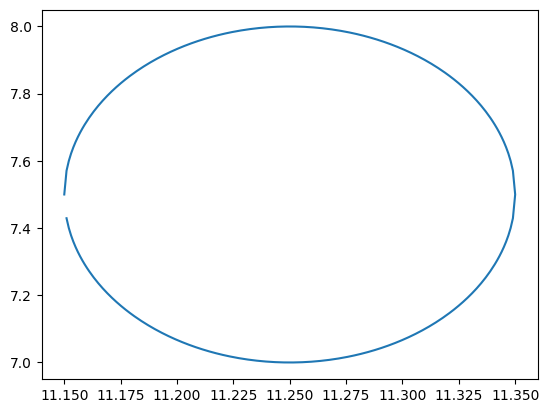

In [33]:
plt.plot(*ellipse_position(0.0))

In [34]:

subgrid_laplacians = get_subgrid_laplacians(grid, boundary_layer_widths)
y = evolve_navier_stokes(global_pressure.array.data, (vx_0.array.data, vy_0.array.data), 
                         grid,boundary_layer_widths, diagonals, 10, dt)
print('FINAL RESULT:\n', y)

FINAL RESULT:
 (Array([[[ 8.93298566e-01,  1.04038525e+00,  7.27573752e-01, ...,
          2.35295906e+01, -7.98832245e+01,  4.87004028e+02],
        [ 9.55249667e-01,  9.14731860e-01,  8.95353377e-01, ...,
          1.60017967e+01, -4.98705444e+01,  3.45619019e+02],
        [ 9.84106243e-01,  9.81900573e-01,  9.78557289e-01, ...,
         -2.32512932e+01,  9.21276550e+01, -5.03654877e+02],
        ...,
        [ 1.05397427e+00,  1.09077013e+00,  1.09465814e+00, ...,
         -2.87287636e+01,  1.15199898e+02, -5.50583374e+02],
        [ 1.07513905e+00,  1.12125957e+00,  8.76307070e-01, ...,
          5.48660583e+01, -1.85564102e+02,  7.98168762e+02],
        [ 1.07958198e+00,  8.09481144e-01,  1.37129855e+00, ...,
         -5.61509171e+01,  1.96776581e+02, -8.76538330e+02]],

       [[ 9.26393151e-01,  8.58807027e-01,  1.03492928e+00, ...,
         -4.17782173e+01,  1.49782578e+02, -7.51906616e+02],
        [ 9.55249667e-01,  9.12670553e-01,  8.98482859e-01, ...,
          1.36864367e+

In [35]:
ux, uy = y

In [36]:
ux, uy = np.array(y[0]), np.array(y[1])

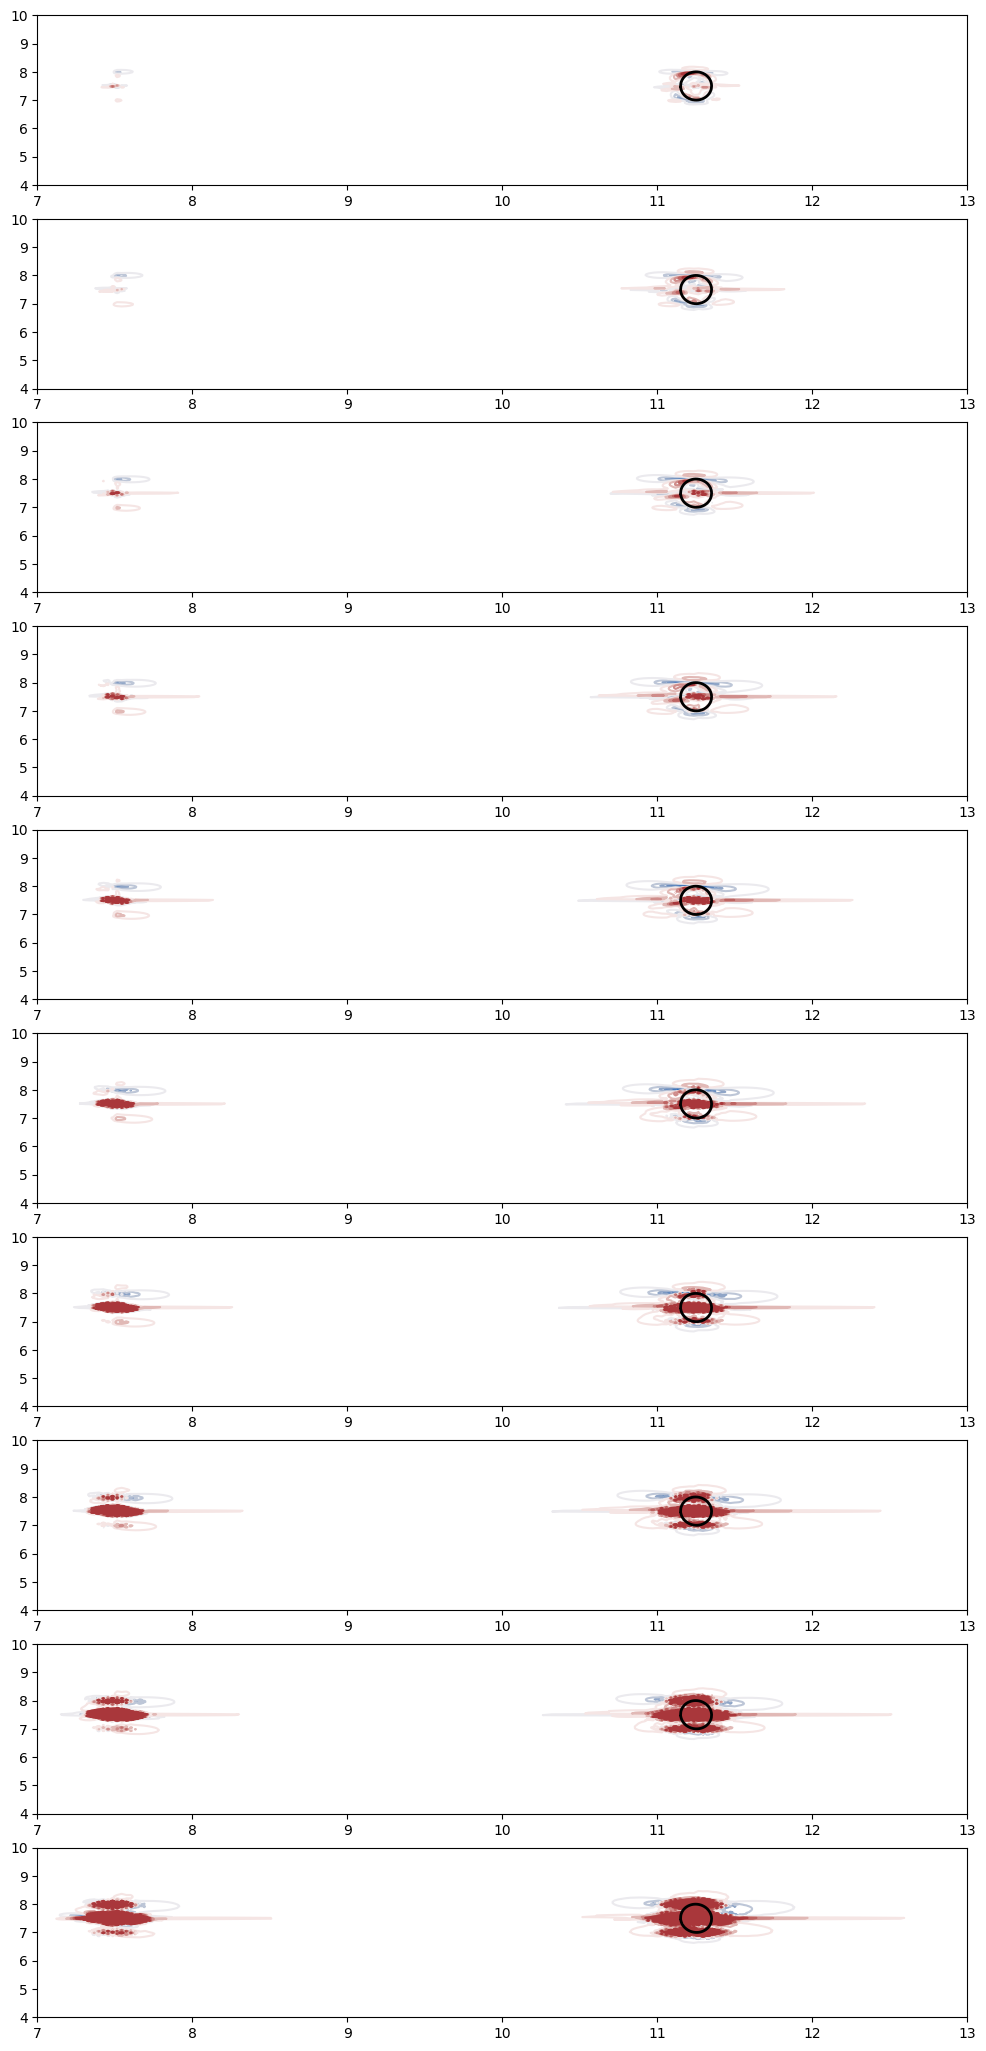

In [37]:
import matplotlib.pyplot as plt
import seaborn
import numpy as np

X,Y = grid.mesh(grid.cell_center)


def calc_vorticity(vx, vy):
    vel_bc = (boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=vx_bc,bc_fn=bc_fns,time_stamp=0.0),
              boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=vx_bc,bc_fn=bc_fns,time_stamp=0.0))


    velocity = tuple([grids.GridVariable(grids.GridArray(u,offset, grid), bc) for u, offset, bc in zip((vx, vy), grid.cell_faces, vel_bc)])
    return finite_differences.central_difference(velocity[1], axis=1).data - finite_differences.central_difference(velocity[0], axis=1).data



fig,ax = plt.subplots(figsize=(12,26),nrows=ux.shape[2])

t = np.arange(ux.shape[2])*dt
counter=0
for idx in range(ux.shape[2]):
    ax[counter].contour(X, Y, calc_vorticity(ux[:,:,idx], uy[:,:,idx]), cmap=seaborn.color_palette("vlag", as_cmap=True), levels=np.linspace(-10, 10, 10))
    xp, yp = ellipse_position(t[idx])
    ax[counter].set_xlim([7,13])
    ax[counter].set_ylim([4,10])
    ax[counter].plot(xp,yp,'k-',linewidth=2.0)
    counter+=1